Missing values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64 

Class distribution (%):
 Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64 



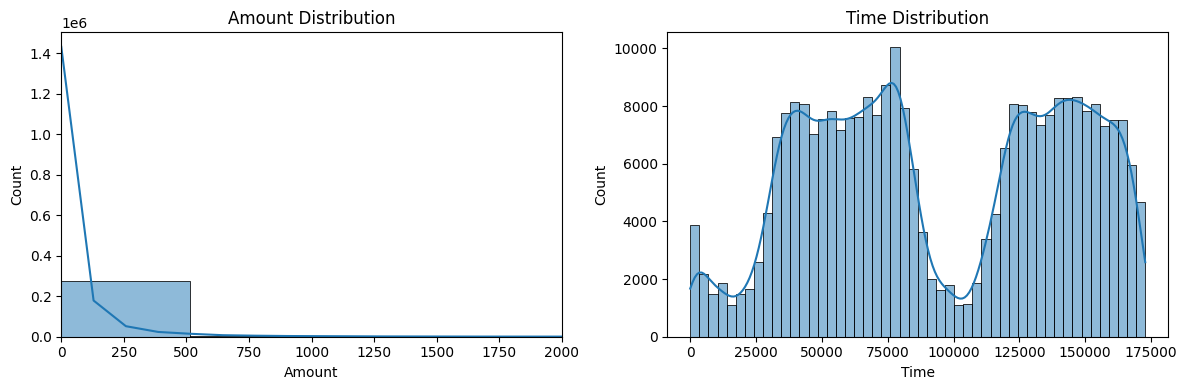

=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9998    0.9774    0.9884     85295
           1     0.0622    0.8649    0.1161       148

    accuracy                         0.9772     85443
   macro avg     0.5310    0.9211    0.5523     85443
weighted avg     0.9981    0.9772    0.9869     85443

ROC-AUC: 0.9677705990180343 

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997     85295
           1     0.9714    0.6892    0.8063       148

    accuracy                         0.9994     85443
   macro avg     0.9854    0.8446    0.9030     85443
weighted avg     0.9994    0.9994    0.9994     85443

ROC-AUC: 0.9468083345083755 

=== XGBoost ===
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     85295
           1     0.8722    0.7838    0.8256       148

    accuracy                         0.9994     85443
  

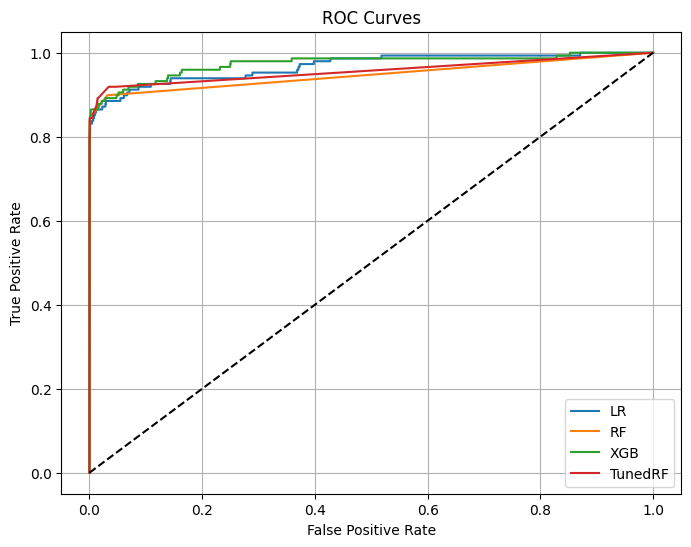

In [1]:
# Complete Credit Card Fraud Detection Pipeline
# ------------------------------------------------
# 1) Install required packages (once):
#    pip install pandas numpy scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    roc_curve
)

# ==== EDIT THIS TO YOUR FILE NAME ====
FILENAME = '3cf2c830-c7ce-4dd1-8e33-6329e9dd27b5.csv'
# ======================================

# 1. Load data
df = pd.read_csv('creditcard.csv')

# 2. Clean data: drop any rows where Class is missing
df = df.dropna(subset=['Class'])

# 3. Exploratory Data Analysis (brief prints)
print("Missing values per column:\n", df.isnull().sum(), "\n")
print("Class distribution (%):\n", df['Class'].value_counts(normalize=True)*100, "\n")

# Optional: visualize Amount and Time
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['Amount'], bins=50, kde=True); plt.title('Amount Distribution'); plt.xlim(0,2000)
plt.subplot(1,2,2)
sns.histplot(df['Time'], bins=50, kde=True); plt.title('Time Distribution')
plt.tight_layout(); plt.show()

# 4. Feature Engineering
# 4.1 Log-transform the Amount to reduce skew
df['Log_Amount'] = np.log(df['Amount'] + 1)
# 4.2 Scale Time and Log_Amount to mean=0, std=1
scaler = StandardScaler()
df[['Time_Scaled','Log_Amount_Scaled']] = scaler.fit_transform(df[['Time','Log_Amount']])
# 4.3 Drop raw features
df = df.drop(['Amount','Log_Amount'], axis=1)

# 5. Prepare features X and target y
X = df.drop('Class', axis=1)
y = df['Class'].astype(int)

# 6. Train/Test split (70/30 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 7. Baseline: Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]), "\n")

# 8. Stronger: Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]), "\n")

# 9. Advanced: XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]), "\n")

# 10. Hyperparameter Tuning for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=8,
    scoring='f1',
    cv=cv,
    random_state=42,
    n_jobs=-1
)
rs.fit(X_train, y_train)
best_rf = rs.best_estimator_
print("Best Random Forest Params:", rs.best_params_, "\n")

# 11. Evaluate Tuned Random Forest
y_pred_best = best_rf.predict(X_test)
print("=== Tuned Random Forest ===")
print(classification_report(y_test, y_pred_best, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), "\n")

# 12. Threshold Optimization on Tuned RF
probs = best_rf.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_ix = np.nanargmax(f1_scores)
best_threshold = thresholds[best_ix]
print(f"Optimal threshold: {best_threshold:.2f}\n")

y_pred_opt = (probs >= best_threshold).astype(int)
print("=== Tuned RF @ Optimal Threshold ===")
print(classification_report(y_test, y_pred_opt, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, probs), "\n")

# 13. ROC Curve Comparison
plt.figure(figsize=(8,6))
for name, model in [('LR', lr), ('RF', rf), ('XGB', xgb), ('TunedRF', best_rf)]:
    p = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [2]:
# best_rf model
model = best_rf  # or xgb, lr, rf — whichever you want to test

In [3]:
sample_txns = X_test.sample(n=5, random_state=42)

In [4]:
import time

for i, txn in sample_txns.iterrows():
    start = time.time()
    score = model.predict_proba([txn])[0][1]  # Get fraud probability
    elapsed = (time.time() - start) * 1000  # in milliseconds

    risk_level = (
        "HIGH (Block)" if score > 0.85 else
        "MEDIUM (Review)" if score > 0.70 else
        "LOW (Approve)"
    )

    print(f"Transaction ID {i}: Score = {score:.4f}, Decision = {risk_level}, Time = {elapsed:.2f} ms")

Transaction ID 109561: Score = 0.0000, Decision = LOW (Approve), Time = 175.63 ms
Transaction ID 7124: Score = 0.0050, Decision = LOW (Approve), Time = 109.77 ms
Transaction ID 133376: Score = 0.0000, Decision = LOW (Approve), Time = 95.28 ms
Transaction ID 117424: Score = 0.0000, Decision = LOW (Approve), Time = 104.97 ms
Transaction ID 188216: Score = 0.0000, Decision = LOW (Approve), Time = 99.87 ms


In [6]:
def score_transaction(txn, model, high_thresh=0.85, med_thresh=0.70):
    start = time.time()
    score = model.predict_proba([txn])[0][1]
    elapsed = (time.time() - start) * 1000
    if score > high_thresh:
        decision = "Block"
    elif score > med_thresh:
        decision = "Send to Reviewer"
    else:
        decision = "Approve"
    return score, decision, elapsed

In [7]:
import time

print("Starting real-time simulation...")
for i in range(10):
    txn = X_test.sample(n=1, random_state=i)
    score, decision, timing = score_transaction(txn.iloc[0], model)
    print(f"Txn {i}: Score={score:.3f}, Decision={decision}, Time={timing:.2f}ms")
    time.sleep(1)  # simulate 1 new transaction per second

Starting real-time simulation...
Txn 0: Score=0.000, Decision=Approve, Time=111.27ms
Txn 1: Score=0.000, Decision=Approve, Time=83.81ms
Txn 2: Score=0.000, Decision=Approve, Time=69.17ms
Txn 3: Score=0.000, Decision=Approve, Time=78.51ms
Txn 4: Score=0.000, Decision=Approve, Time=87.24ms
Txn 5: Score=0.000, Decision=Approve, Time=67.92ms
Txn 6: Score=0.005, Decision=Approve, Time=74.75ms
Txn 7: Score=0.000, Decision=Approve, Time=89.41ms
Txn 8: Score=0.000, Decision=Approve, Time=83.86ms
Txn 9: Score=0.000, Decision=Approve, Time=64.80ms


In [8]:
# Get indices of known frauds in test set
fraud_indices = y_test[y_test == 1].index

# Sample a few fraud transactions
fraud_samples = X_test.loc[fraud_indices].sample(n=5, random_state=42)

for i, txn in fraud_samples.iterrows():
    score, decision, timing = score_transaction(txn, model)
    print(f"Fraud Txn {i}: Score={score:.3f}, Decision={decision}, Time={timing:.2f}ms")


Fraud Txn 52584: Score=0.950, Decision=Block, Time=111.16ms
Fraud Txn 42958: Score=0.820, Decision=Send to Reviewer, Time=105.67ms
Fraud Txn 41569: Score=0.790, Decision=Send to Reviewer, Time=81.49ms
Fraud Txn 214662: Score=0.850, Decision=Send to Reviewer, Time=79.62ms
Fraud Txn 149577: Score=0.125, Decision=Approve, Time=86.52ms
